In [1]:
from typing import Iterable, Sequence, cast

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn import metrics, model_selection
from torch.utils.data import DataLoader

import sentence_topology as st
from sentence_topology.data_types import CostraSentence

In [2]:
def gen_confusion_matricies(
    corpus: list[CostraSentence],
    sentence_model: str,
    *,
    splits: int = 5,
    epochs: int = 5,
    verbose: bool = False,
) -> Iterable[pd.DataFrame]:
    kfold = model_selection.StratifiedGroupKFold(n_splits=splits)
    data = st.sentence_transformers.create_transformation_prediction_data(corpus)
    classes = cast(Sequence[str], data.label_encoder.classes_)

    for train_inds, test_inds in kfold.split(
        data.sent_pairs, y=data.trans, groups=data.seed_ids
    ):
        train = [data.sent_pairs[i] for i in train_inds]
        train = DataLoader(train, batch_size=8, shuffle=True)
        test = [data.sent_pairs[i] for i in test_inds]
        test = DataLoader(test, batch_size=8)

        model = SentenceTransformer(sentence_model)
        classifier = st.sentence_transformers.train_with_transformation_prediction(
            model=model,
            train_data=train,
            test_data=test,
            epochs=epochs,
            num_labels=len(classes),
            verbose=verbose,
        )

        predicion_results = st.sentence_transformers.train.predict_with_classifier(
            test, classifier, model
        )
        all_preds = []
        all_true = []
        for prediction, label_ids in predicion_results:
            all_preds.append(prediction.numpy(force=True))
            all_true.append(label_ids.numpy(force=True))

        all_preds = np.concatenate(all_preds)
        all_true = np.concatenate(all_true)

        yield pd.DataFrame(
            metrics.confusion_matrix(all_true, all_preds),
            columns=classes,
            index=classes,
        )

In [3]:
MODEL = "paraphrase-multilingual-MiniLM-L12-v2"
SPLITS = 5
corpus = list(st.utils.load_corpus("../data/COSTRA1.1.tsv"))
matricies = gen_confusion_matricies(corpus, MODEL, verbose=True, splits=SPLITS)
matricies = list(matricies)

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/698 [00:00<?, ?it/s]

Iteration:   0%|          | 0/698 [00:00<?, ?it/s]

Iteration:   0%|          | 0/698 [00:00<?, ?it/s]

Iteration:   0%|          | 0/698 [00:00<?, ?it/s]

Iteration:   0%|          | 0/698 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/698 [00:00<?, ?it/s]

Iteration:   0%|          | 0/698 [00:00<?, ?it/s]

Iteration:   0%|          | 0/698 [00:00<?, ?it/s]

Iteration:   0%|          | 0/698 [00:00<?, ?it/s]

Iteration:   0%|          | 0/698 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/695 [00:00<?, ?it/s]

Iteration:   0%|          | 0/695 [00:00<?, ?it/s]

Iteration:   0%|          | 0/695 [00:00<?, ?it/s]

Iteration:   0%|          | 0/695 [00:00<?, ?it/s]

Iteration:   0%|          | 0/695 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/697 [00:00<?, ?it/s]

Iteration:   0%|          | 0/697 [00:00<?, ?it/s]

Iteration:   0%|          | 0/697 [00:00<?, ?it/s]

Iteration:   0%|          | 0/697 [00:00<?, ?it/s]

Iteration:   0%|          | 0/697 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/699 [00:00<?, ?it/s]

Iteration:   0%|          | 0/699 [00:00<?, ?it/s]

Iteration:   0%|          | 0/699 [00:00<?, ?it/s]

Iteration:   0%|          | 0/699 [00:00<?, ?it/s]

Iteration:   0%|          | 0/699 [00:00<?, ?it/s]

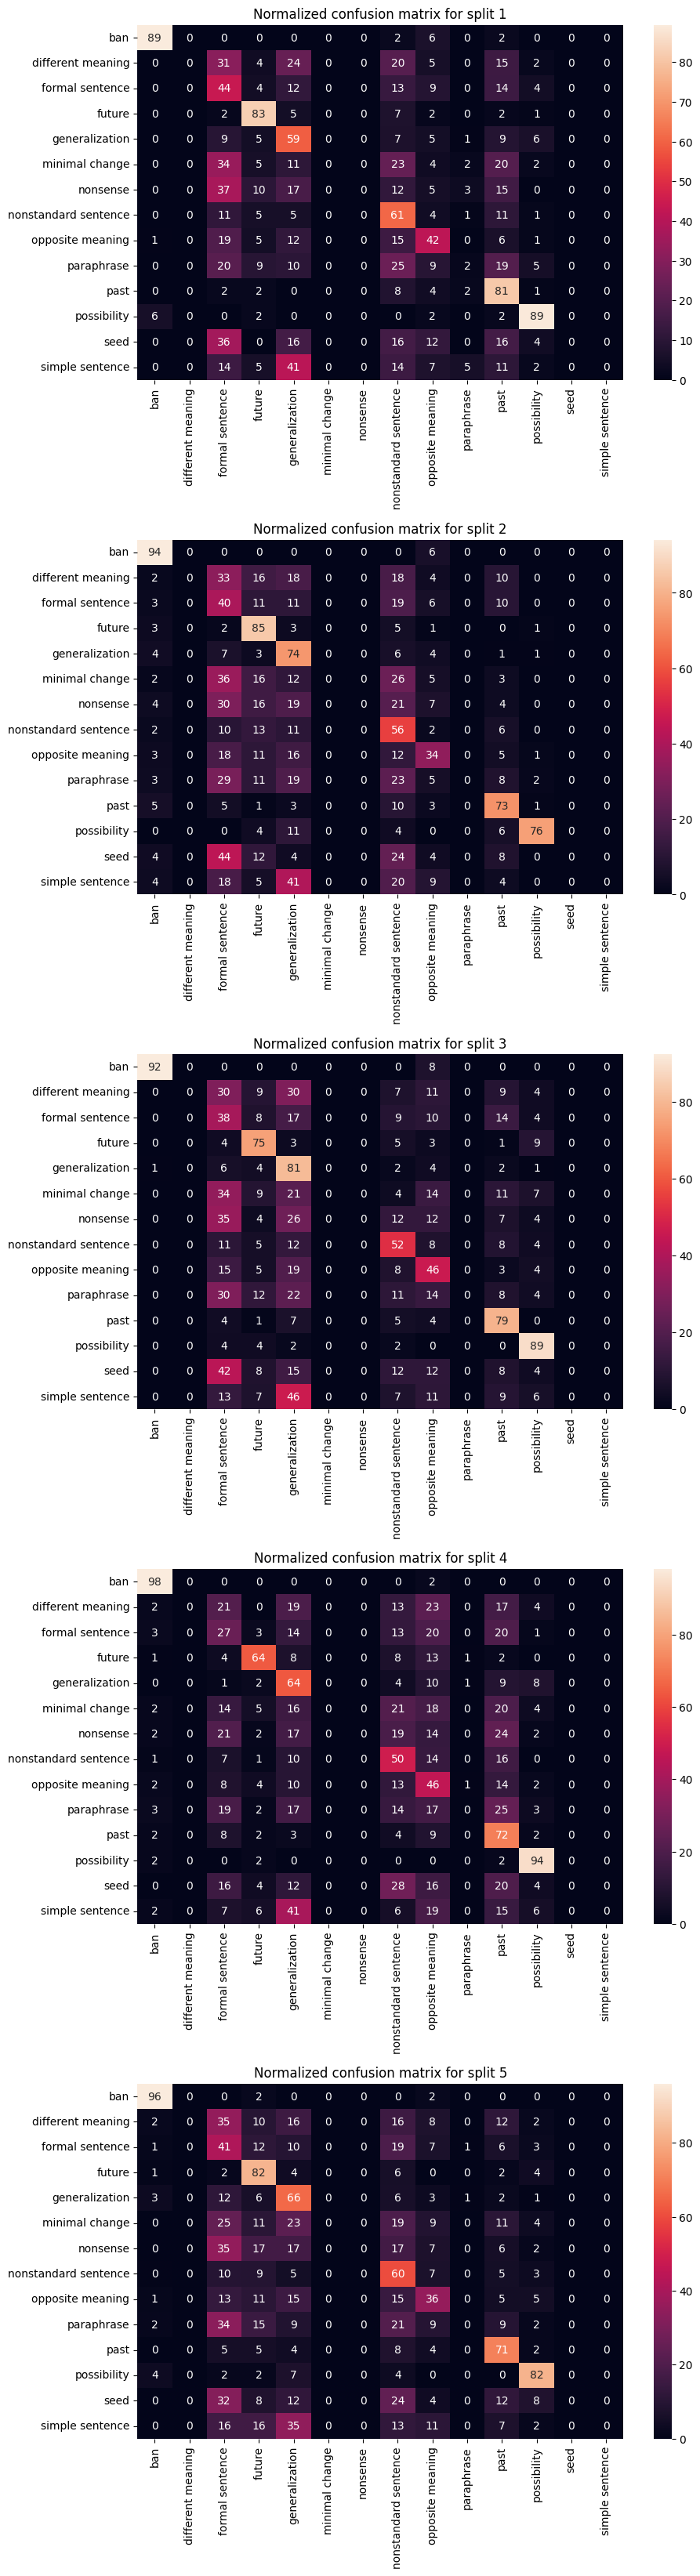

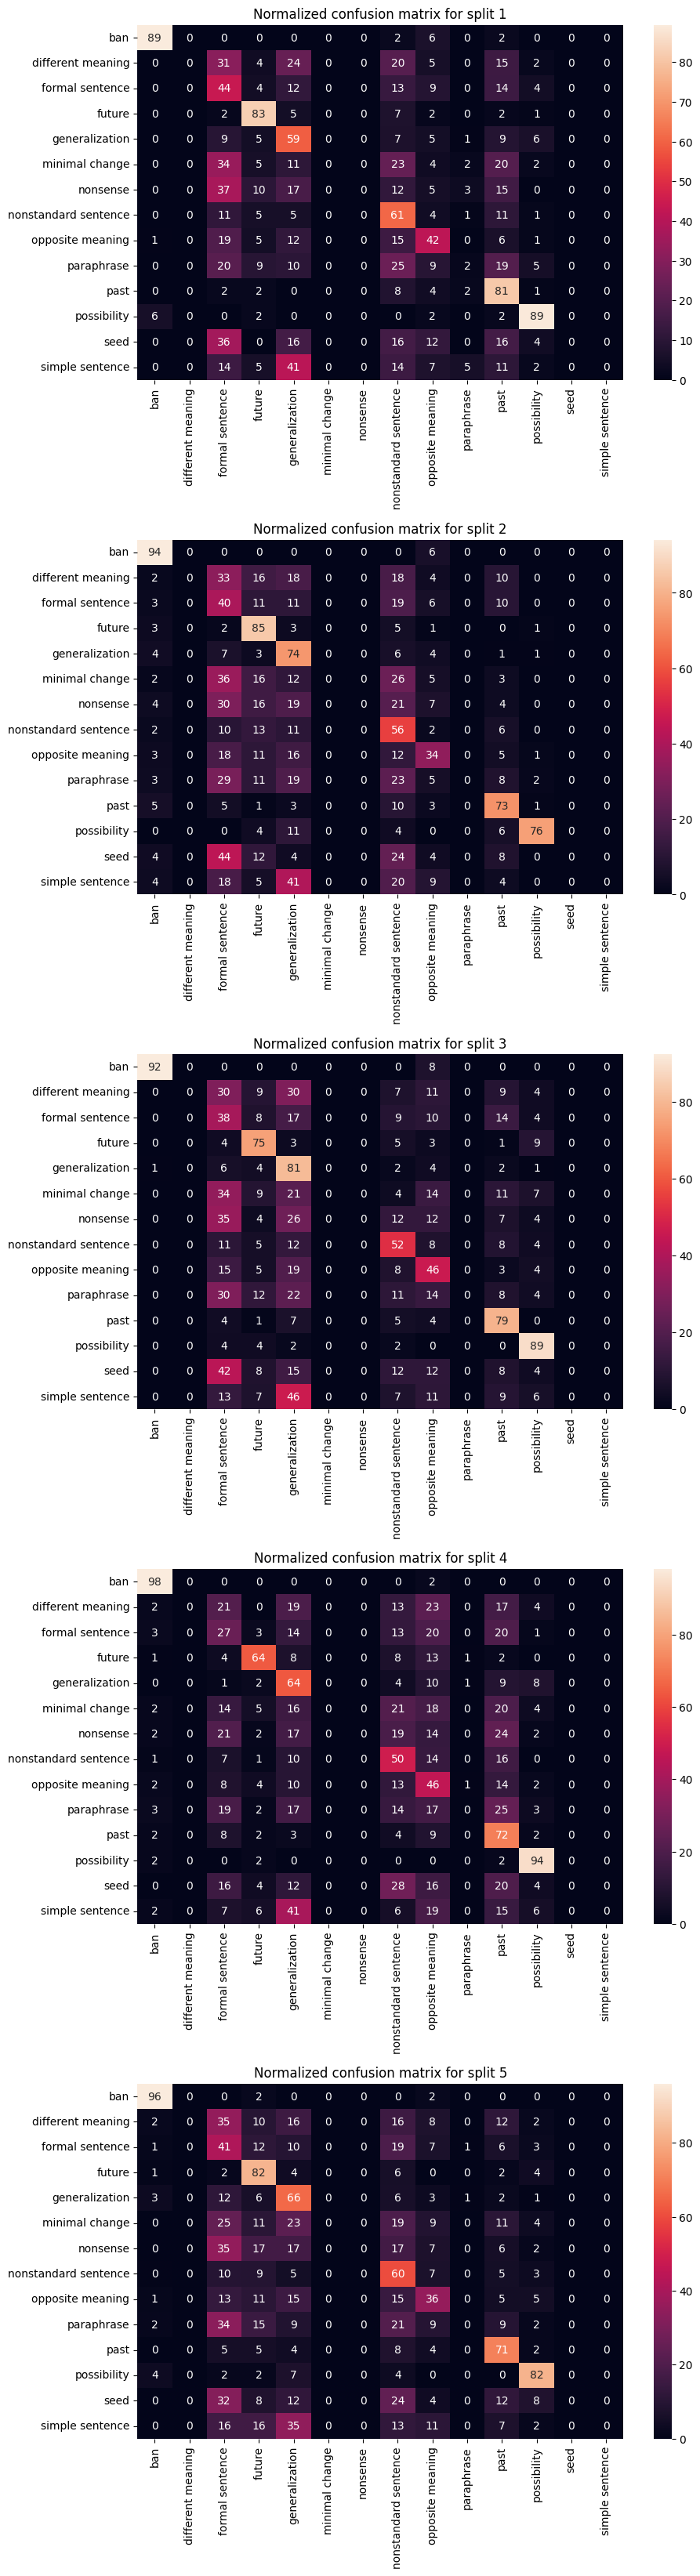

In [4]:
fig, subplots = plt.subplots(
    SPLITS,
    1,
    figsize=(10, 8 * SPLITS),
    gridspec_kw={"hspace": 0.45},
)
subplots = np.reshape(subplots, (-1,))

for split_ind, (matrix, axes) in enumerate(zip(matricies, subplots)):
    axes.set_title(f"Normalized confusion matrix for split {split_ind + 1}")
    st.visualization.confusion_matrix(matrix, axes)

fig

In [5]:
fig.savefig("../figs/sbert_confusion_matricies_norm.png", bbox_inches="tight")